# [Домашнє завдання до модуля «Алгоритми навчання з вчителем Ч.2»](https://www.edu.goit.global/uk/learn/25315460/23598278/25121681/homework)
___

## Імпорт необхідних модулів

In [1]:
#!pip install kaggle
import os
import zipfile

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, confusion_matrix
import seaborn as sns
from imblearn.over_sampling import SMOTE

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 1000)

## 1. Завантаження даних

[Logistic Regression Tutorial CSEC](https://www.kaggle.com/code/samuelkeno/logistic-regression-tutorial-csec#Logistic-Regression)

In [2]:
# !kaggle datasets download -d jsphyg/weather-dataset-rattle-package --unzip
import os

print("Files in current directory:", os.listdir("."))

if os.path.exists("weatherAUS.csv"):
	data = pd.read_csv("weatherAUS.csv")
	print("Successfully loaded weatherAUS.csv")
else:
	print("Error: weatherAUS.csv not found.")

Files in current directory: ['weatherAUS.csv', 'dz_topic_05_ZubchykMM.ipynb', 'dz_topic_03_ZubchykMM.ipynb', 'dz_mod_02_my_name.py']
Successfully loaded weatherAUS.csv


In [3]:
df = pd.read_csv("weatherAUS.csv")
display(df.shape)
display(df.head(2))

(145460, 23)

,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No


- `RainTomorrow` is the target variable to predict. It answers the crucial question: will it rain the next day? (Yes or No). This column is marked 'Yes' if the rain for that day was 1mm or more.


## 2. EDA

### Перевірка типів даних і відсутніх значень

In [4]:
columns_na_sum = df.isna().sum()
columns_na_ratio = df.isna().mean()
na_df = pd.concat([columns_na_sum, columns_na_ratio], axis=1)
na_df.columns = ["NA Sum", "NA Ratio"]
na_df.sort_values(by="NA Sum", ascending=False, inplace=True)
display(na_df)

df.info()

,NA Sum,NA Ratio
Sunshine,69835,0.480098
Evaporation,62790,0.431665
Cloud3pm,59358,0.408071
Cloud9am,55888,0.384216
Pressure9am,15065,0.103568
Pressure3pm,15028,0.103314
WindDir9am,10566,0.072639
WindGustDir,10326,0.070989
WindGustSpeed,10263,0.070555
Humidity3pm,4507,0.030984


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145460 entries, 0 to 145459
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Date           145460 non-null  object 
 1   Location       145460 non-null  object 
 2   MinTemp        143975 non-null  float64
 3   MaxTemp        144199 non-null  float64
 4   Rainfall       142199 non-null  float64
 5   Evaporation    82670 non-null   float64
 6   Sunshine       75625 non-null   float64
 7   WindGustDir    135134 non-null  object 
 8   WindGustSpeed  135197 non-null  float64
 9   WindDir9am     134894 non-null  object 
 10  WindDir3pm     141232 non-null  object 
 11  WindSpeed9am   143693 non-null  float64
 12  WindSpeed3pm   142398 non-null  float64
 13  Humidity9am    142806 non-null  float64
 14  Humidity3pm    140953 non-null  float64
 15  Pressure9am    130395 non-null  float64
 16  Pressure3pm    130432 non-null  float64
 17  Cloud9am       89572 non-null

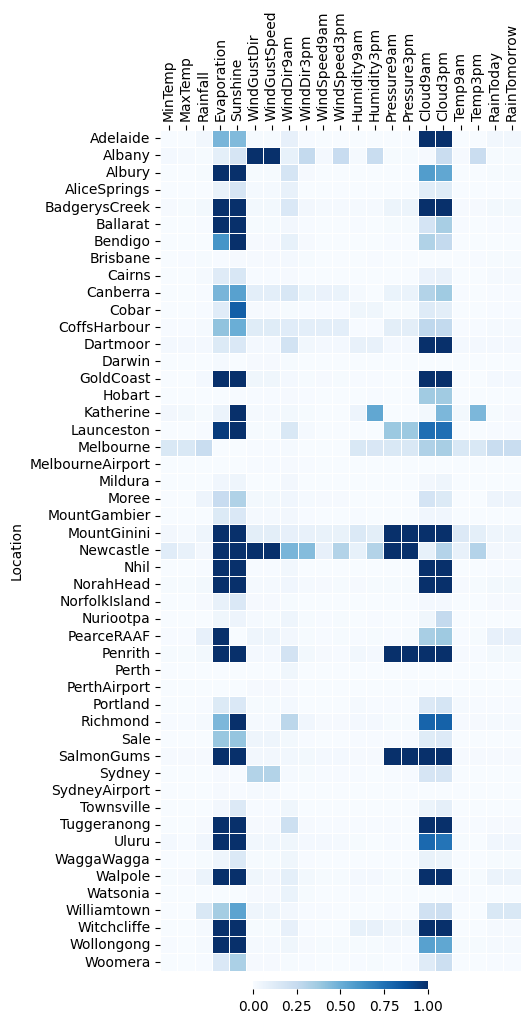

In [5]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    tmp = df.groupby("Location").apply(
        lambda x: x.drop(["Location", "Date"], axis=1).isna().mean()
    )

plt.figure(figsize=(9, 13))

ax = sns.heatmap(
    tmp,
    cmap="Blues",
    linewidth=0.5,
    square=True,
    cbar_kws=dict(location="bottom", pad=0.01, shrink=0.25),
)

ax.xaxis.tick_top()
ax.tick_params(axis="x", labelrotation=90)

### Видалення ознак, де пропусків > 35% та де цільова змінна `RainTomorrow` відсутня

In [6]:
print(f"Original data shape: {data.shape}")

df = df[df.columns[df.isna().mean().lt(0.35)]]
df = df.dropna(subset="RainTomorrow")

print(f"Data shape after removing features with many missing values: {df.shape}")
display(df.head(2))

Original data shape: (145460, 23)
Data shape after removing features with many missing values: (142193, 19)


,Date,Location,MinTemp,MaxTemp,Rainfall,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,W,44.0,W,WNW,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,WNW,44.0,NNW,WSW,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,No,No


### Розподіл ознак

#### Створeння підмножин набору даних із числовими та категоріальними ознаками.

In [7]:
df_num = df.select_dtypes(include=np.number)
df_cat = df.select_dtypes(include="object").copy()

display(df_num.head(2))
display(df_cat.head(2))

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3


,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,W,W,WNW,No,No
1,2008-12-02,Albury,WNW,NNW,WSW,No,No


#### Зміна типу колонки `Date` на тип `datetime` та ствровення колонок: `Year`, `Month`.

In [8]:
df_cat["Date"] = pd.to_datetime(df["Date"])
df_cat["Year"] = df_cat["Date"].dt.year
df_cat["Month"] = df_cat["Date"].dt.month

display(df_cat.head(2))

,Date,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow,Year,Month
0,2008-12-01,Albury,W,W,WNW,No,No,2008,12
1,2008-12-02,Albury,WNW,NNW,WSW,No,No,2008,12


 #### Переміщення колонки `Year` з підмножини набору із категоріальними ознаками до підмножини із числовими ознаками.

In [9]:
df_num["Year"] = df_cat["Year"]
df_cat.drop("Date", axis=1, inplace=True)
df_cat["Month"] = df_cat["Month"].astype(str)

display(df_num.head(2))
display(df_cat.head(2))

,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Year
0,13.4,22.9,0.6,44.0,20.0,24.0,71.0,22.0,1007.7,1007.1,16.9,21.8,2008
1,7.4,25.1,0.0,44.0,4.0,22.0,44.0,25.0,1010.6,1007.8,17.2,24.3,2008


,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow,Year,Month
0,Albury,W,W,WNW,No,No,2008,12
1,Albury,WNW,NNW,WSW,No,No,2008,12


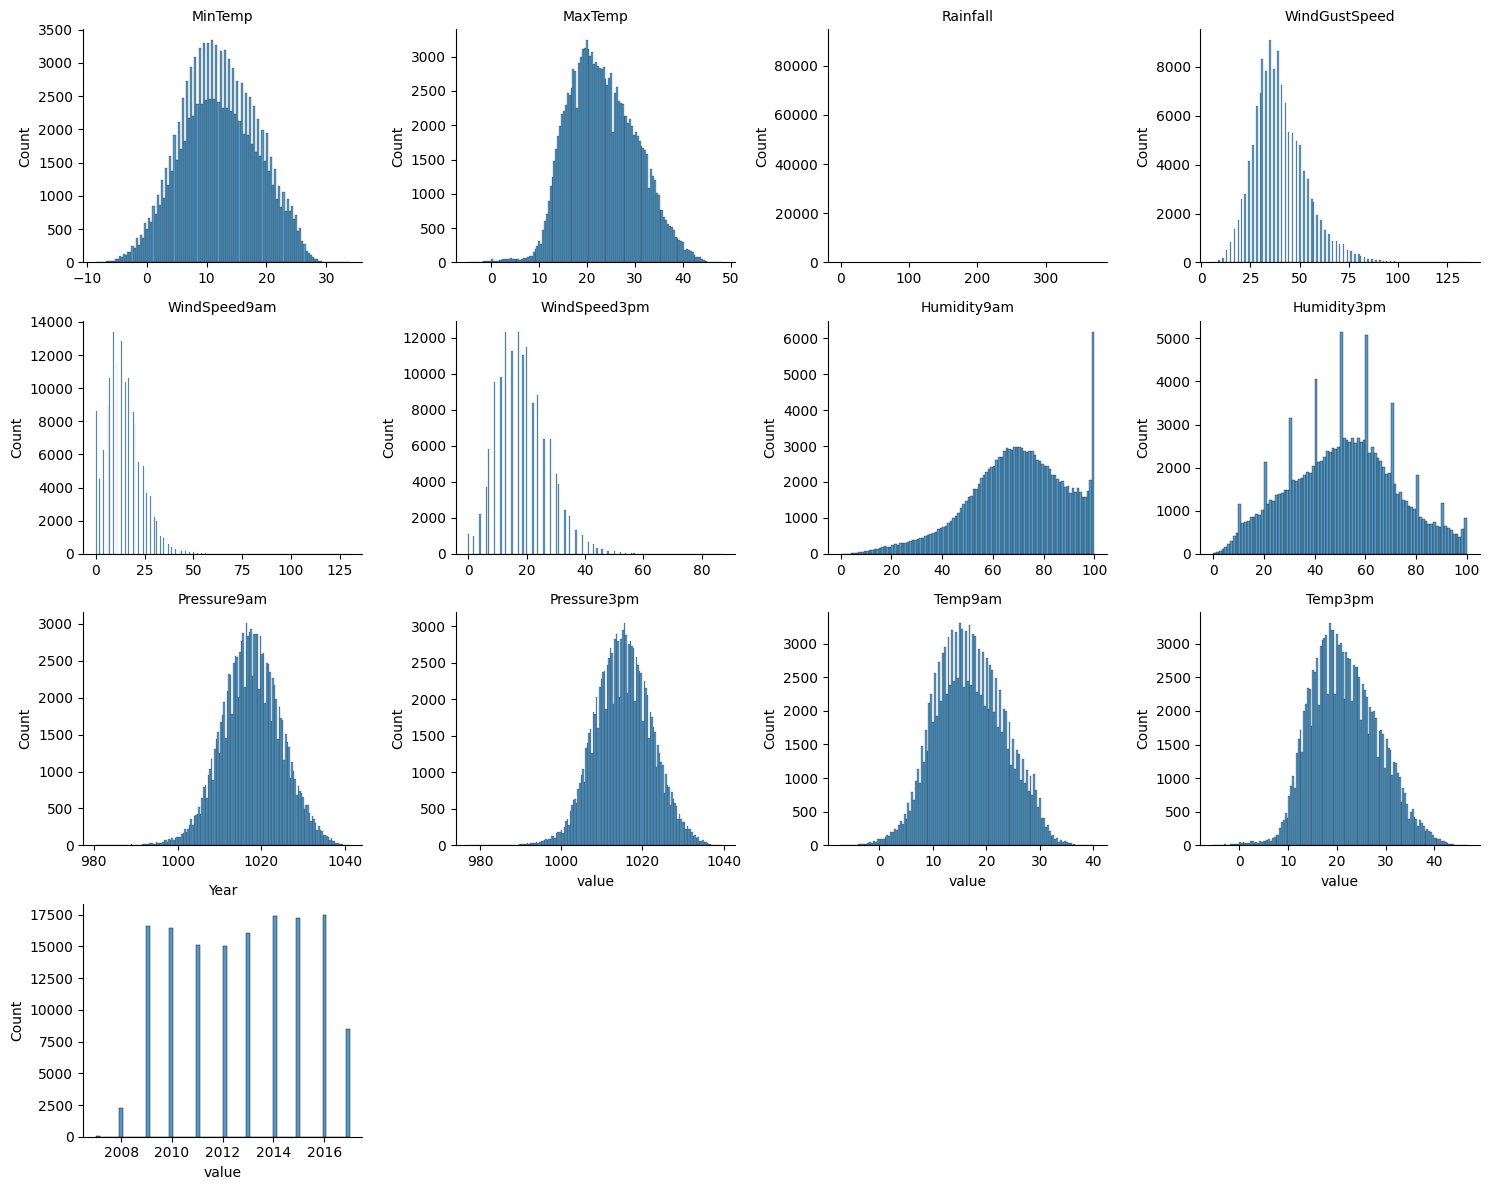

In [10]:
melted = df_num.melt()

g = sns.FacetGrid(melted, col="variable", col_wrap=4, sharex=False, sharey=False, aspect=1.25)

g.map(sns.histplot, "value")
g.set_titles(col_template="{col_name}")
g.tight_layout()

#### Розбиття підмножини на тренувальну і тестову вибірки за такою логікою: до тестової вибірки відносяться всі об'єкти із набору даних із останнім (максимальним) роком спостережень, а для навчання моделі залишаються всі інші об'єкти.

In [11]:
max_year = df_num["Year"].max()
print(f"The maximum year in the dataset is: {max_year}")

is_test = df_num["Year"] == max_year
is_train = ~is_test

origin_X_train_num = df_num[is_train].drop("Year", axis=1)
origin_X_test_num = df_num[is_test].drop("Year", axis=1)

origin_X_train_cat = df_cat[is_train].drop(["RainTomorrow", "Year"], axis=1)
origin_X_test_cat = df_cat[is_test].drop(["RainTomorrow", "Year"], axis=1)

y_train = df["RainTomorrow"][is_train]
y_test = df["RainTomorrow"][is_test]

print(f"Training set size: {len(origin_X_train_num)}")
print(f"Test set size: {len(origin_X_test_num)}")

print(f"\nNaN values in numerical training data before imputation: {origin_X_train_num.isna().sum().sum()}")
print(f"NaN values in categorical training data before imputation: {origin_X_train_cat.isna().sum().sum()}")

The maximum year in the dataset is: 2017
Training set size: 133727
Test set size: 8466

NaN values in numerical training data before imputation: 48638
NaN values in categorical training data before imputation: 22991


## 3. Відновлення пропущених даних за допомогою об'єкта `SimpleImputer` з пакету `sklearn`.

In [12]:
num_imputer = SimpleImputer().set_output(transform="pandas")
X_train_num = num_imputer.fit_transform(origin_X_train_num)
X_test_num = num_imputer.transform(origin_X_test_num)

cat_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")
X_train_cat = cat_imputer.fit_transform(origin_X_train_cat)
X_test_cat = cat_imputer.transform(origin_X_test_cat)

print(f"\nNaN values in numerical training data after imputation: {X_train_num.isna().sum().sum()}")
print(f"NaN values in numerical test data after imputation: {X_test_num.isna().sum().sum()}")
print(f"NaN values in categorical training data after imputation: {X_train_cat.isna().sum().sum()}")
print(f"NaN values in categorical test data after imputation: {X_test_cat.isna().sum().sum()}")


NaN values in numerical training data after imputation: 0
NaN values in numerical test data after imputation: 0
NaN values in categorical training data after imputation: 0
NaN values in categorical test data after imputation: 0


## 4. Нормалізація числових ознак за допомогою об'єкта `StandardScaler` з пакету `sklearn`.

In [13]:
scaler = StandardScaler().set_output(transform="pandas")
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

print(f"\nNaN values in numerical training data after scaling: {X_train_num.isna().sum().sum()}")
print(f"NaN values in numerical test data after scaling: {X_test_num.isna().sum().sum()}")


NaN values in numerical training data after scaling: 0
NaN values in numerical test data after scaling: 0


In [14]:
if X_train_num.isna().sum().sum() > 0:
    X_train_num = X_train_num.fillna(0)
    print("Filled NaNs in training numerical data with 0")

if X_test_num.isna().sum().sum() > 0:
    X_test_num = X_test_num.fillna(0)
    print("Filled NaNs in test numerical data with 0")

## 6. Кодування категоріальних ознак за допомогою об’єкта `OneHotEncoder` з пакету `sklearn`.

In [15]:
encoder = OneHotEncoder(
    drop="if_binary", sparse_output=False, handle_unknown="ignore"
).set_output(transform="pandas")
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)

print(f"\nNaN values in numerical training data after encoding: {X_train_num.isna().sum().sum()}")
print(f"NaN values in numerical test data after encoding: {X_test_num.isna().sum().sum()}")


NaN values in numerical training data after encoding: 0
NaN values in numerical test data after encoding: 0


## 7. Об'єднання підмножин з числовими і категоріальними ознаками для побудови моделі за допомогою об’єкта `LogisticRegression` з пакету `sklearn`.

In [16]:
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)

print(f"Final training data shape: {X_train.shape}")
print(f"Final test data shape: {X_test.shape}")

print("\nTarget variable distribution in training set:")
print(y_train.value_counts(normalize=True))

print("\nTarget variable distribution in test set:")
print(y_test.value_counts(normalize=True))

print(f"\nNaN values in combined training data: {X_train_num.isna().sum().sum()}")
print(f"NaN values in combined test data: {X_test_num.isna().sum().sum()}")

Final training data shape: (133727, 122)
Final test data shape: (8466, 122)

Target variable distribution in training set:
RainTomorrow
No     0.77481
Yes    0.22519
Name: proportion, dtype: float64

Target variable distribution in test set:
RainTomorrow
No     0.791755
Yes    0.208245
Name: proportion, dtype: float64

NaN values in combined training data: 0
NaN values in combined test data: 0


In [17]:
if X_train.isna().sum().sum() > 0:
    X_train = X_train.fillna(0)
    print("Filled remaining NaNs in training data with 0")

if X_test.isna().sum().sum() > 0:
    X_test = X_test.fillna(0)
    print("Filled remaining NaNs in test data with 0")

In [18]:
print(f"Final training data shape: {X_train.shape}")
print(f"Final test data shape: {X_test.shape}")

display(X_train.head(2))
display(X_test.head(2))

Final training data shape: (133727, 122)
Final test data shape: (8466, 122)


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
0,0.205482,-0.030108,-0.207381,0.292771,0.667526,0.602373,0.121932,-1.433143,-1.470784,-1.216395,-0.001583,0.031333,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,-0.736944,0.279808,-0.278796,0.292771,-1.134272,0.373916,-1.303491,-1.287215,-1.040659,-1.111524,0.044840,0.395202,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


,MinTemp,MaxTemp,Rainfall,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Temp9am,Temp3pm,Location_Adelaide,Location_Albany,Location_Albury,Location_AliceSprings,Location_BadgerysCreek,Location_Ballarat,Location_Bendigo,Location_Brisbane,Location_Cairns,Location_Canberra,Location_Cobar,Location_CoffsHarbour,Location_Dartmoor,Location_Darwin,Location_GoldCoast,Location_Hobart,Location_Katherine,Location_Launceston,Location_Melbourne,Location_MelbourneAirport,Location_Mildura,Location_Moree,Location_MountGambier,Location_MountGinini,Location_Newcastle,Location_Nhil,Location_NorahHead,Location_NorfolkIsland,Location_Nuriootpa,Location_PearceRAAF,Location_Penrith,Location_Perth,Location_PerthAirport,Location_Portland,Location_Richmond,Location_Sale,Location_SalmonGums,Location_Sydney,Location_SydneyAirport,Location_Townsville,Location_Tuggeranong,Location_Uluru,Location_WaggaWagga,Location_Walpole,Location_Watsonia,Location_Williamtown,Location_Witchcliffe,Location_Wollongong,Location_Woomera,WindGustDir_E,WindGustDir_ENE,WindGustDir_ESE,WindGustDir_N,WindGustDir_NE,WindGustDir_NNE,WindGustDir_NNW,WindGustDir_NW,WindGustDir_S,WindGustDir_SE,WindGustDir_SSE,WindGustDir_SSW,WindGustDir_SW,WindGustDir_W,WindGustDir_WNW,WindGustDir_WSW,WindDir9am_E,WindDir9am_ENE,WindDir9am_ESE,WindDir9am_N,WindDir9am_NE,WindDir9am_NNE,WindDir9am_NNW,WindDir9am_NW,WindDir9am_S,WindDir9am_SE,WindDir9am_SSE,WindDir9am_SSW,WindDir9am_SW,WindDir9am_W,WindDir9am_WNW,WindDir9am_WSW,WindDir3pm_E,WindDir3pm_ENE,WindDir3pm_ESE,WindDir3pm_N,WindDir3pm_NE,WindDir3pm_NNE,WindDir3pm_NNW,WindDir3pm_NW,WindDir3pm_S,WindDir3pm_SE,WindDir3pm_SSE,WindDir3pm_SSW,WindDir3pm_SW,WindDir3pm_W,WindDir3pm_WNW,WindDir3pm_WSW,RainToday_Yes,Month_1,Month_10,Month_11,Month_12,Month_2,Month_3,Month_4,Month_5,Month_6,Month_7,Month_8,Month_9
2864,0.535331,1.195471,-0.278796,-0.086738,-0.57121,0.602373,-0.300416,-1.287215,-1.856413,-1.665844,1.004247,1.428589,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2865,0.441088,1.251820,-0.278796,-0.390346,-0.57121,-1.111055,-0.300416,-1.044002,-0.966500,-0.796910,0.570966,1.297596,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 8. Експерименти

In [19]:
def compare_solvers(X_train, y_train, X_test, y_test):
    solvers = ["liblinear", "lbfgs", "newton-cg", "sag", "saga"]
    results = {}
    
    print("\nComparing different solvers:")
    for solver in solvers:
        try:
            clf = LogisticRegression(
                solver=solver,
                class_weight="balanced",
                max_iter=2000,
                random_state=42,
            )
            clf.fit(X_train, y_train)
            pred = clf.predict(X_test)

            report = classification_report(y_test, pred, output_dict=True)
            results[solver] = report

            print(f"\nResults for solver: {solver}")
            print(f"Accuracy: {report['accuracy']:.4f}")
            print(f"Weighted F1-score: {report['weighted avg']['f1-score']:.4f}")
        except Exception as e:
            print(f"Error with solver {solver}: {e}")

    if results:
        best_solver = max(results, key=lambda x: results[x]["weighted avg"]["f1-score"])
        print(f"\nBest solver: {best_solver}")

        clf_final = LogisticRegression(
            solver=best_solver, class_weight="balanced", max_iter=2000, random_state=42
        ).fit(X_train, y_train)
        pred_final = clf_final.predict(X_test)

        print("\nConfusion Matrix:")
        fig, ax = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_test, pred_final, ax=ax)
        plt.title(f"Confusion Matrix (Solver: {best_solver})")
        plt.show()

        print("\nClassification Report:")
        print(classification_report(y_test, pred_final))

        if hasattr(clf_final, "coef_"):
            coef = pd.DataFrame(
                clf_final.coef_.T, index=X_train.columns, columns=["Coefficient"]
            )
            top_features = coef.abs().sort_values("Coefficient", ascending=False).head(15)

            plt.figure(figsize=(10, 8))
            sns.barplot(x="Coefficient", y=top_features.index, data=top_features)
            plt.title("Top 15 Feature Importance")
            plt.tight_layout()
            plt.show()

        return clf_final, best_solver, results

    else:
        print("\nNo valid solver found. Using a fallback approach with default solver:")
        clf_fallback = LogisticRegression(
            class_weight="balanced",
            random_state=42,
            max_iter=5000,
        ).fit(X_train, y_train)
        pred_fallback = clf_fallback.predict(X_test)

        print("\nFallback model classification report:")
        print(classification_report(y_test, pred_fallback))

        fig, ax = plt.subplots(figsize=(8, 6))
        ConfusionMatrixDisplay.from_predictions(y_test, pred_fallback, ax=ax)
        plt.title("Confusion Matrix (Fallback Model)")
        plt.show()
        
        return clf_fallback, None, results

### `SimpleImputer`


Comparing different solvers:

Results for solver: liblinear
Accuracy: 0.8011
Weighted F1-score: 0.8118

Results for solver: lbfgs
Accuracy: 0.8009
Weighted F1-score: 0.8116

Results for solver: newton-cg
Accuracy: 0.8011
Weighted F1-score: 0.8118

Results for solver: sag
Accuracy: 0.8011
Weighted F1-score: 0.8118

Results for solver: saga
Accuracy: 0.8011
Weighted F1-score: 0.8118

Best solver: liblinear

Confusion Matrix:


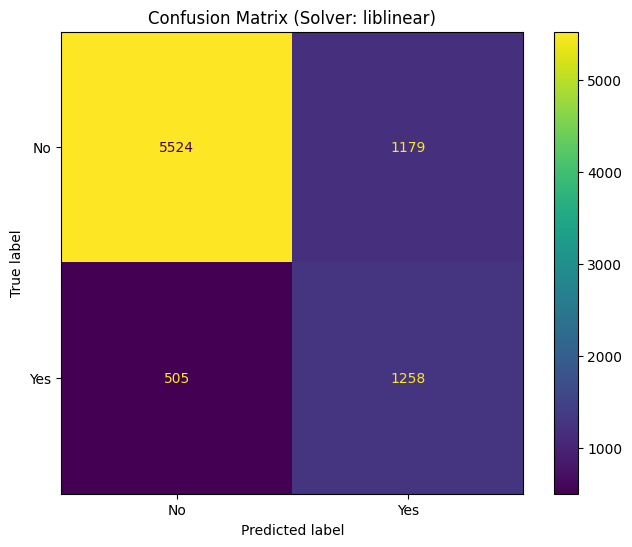


Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.52      0.71      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.72      0.77      0.73      8466
weighted avg       0.83      0.80      0.81      8466



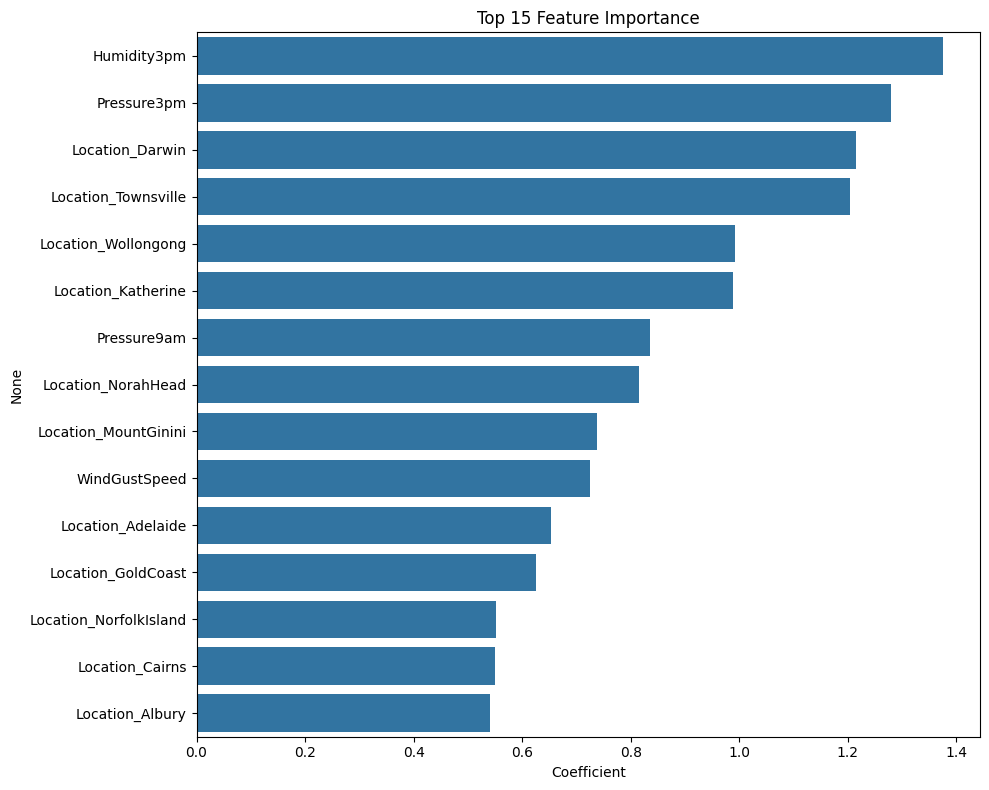

In [20]:
clf_final, best_solver, results = compare_solvers(X_train, y_train, X_test, y_test)

#### `SMOTE`

RainTomorrow
No     103613
Yes    103613
Name: count, dtype: int64

Comparing different solvers:

Results for solver: liblinear
Accuracy: 0.7999
Weighted F1-score: 0.8107

Results for solver: lbfgs
Accuracy: 0.7997
Weighted F1-score: 0.8105

Results for solver: newton-cg
Accuracy: 0.8000
Weighted F1-score: 0.8108

Results for solver: sag
Accuracy: 0.7999
Weighted F1-score: 0.8107

Results for solver: saga
Accuracy: 0.7999
Weighted F1-score: 0.8107

Best solver: newton-cg

Confusion Matrix:


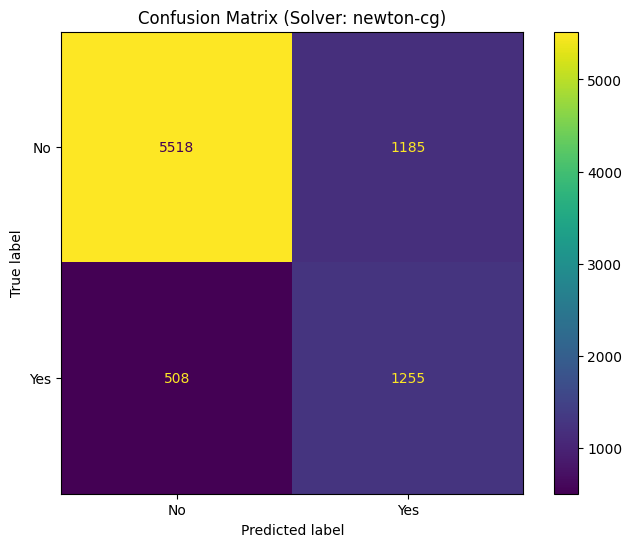


Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.51      0.71      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.72      0.77      0.73      8466
weighted avg       0.83      0.80      0.81      8466



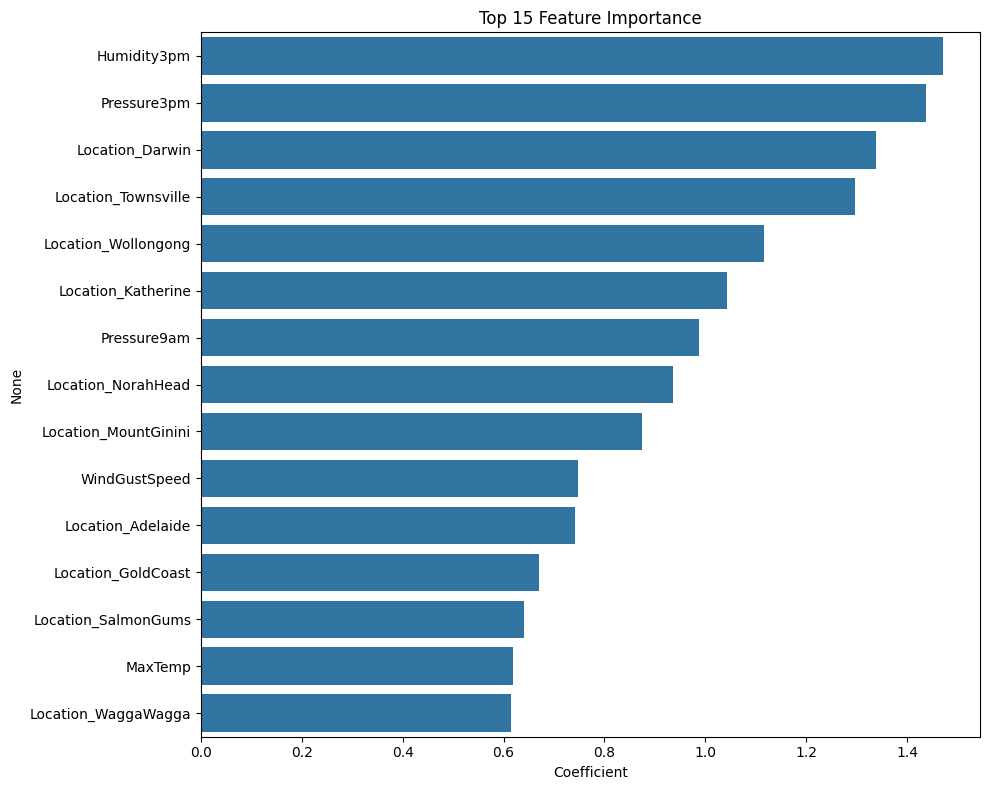

In [21]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(y_train_bal.value_counts())

clf_final, best_solver, results = compare_solvers(
    X_train_bal, y_train_bal, X_test, y_test
)

### `KNNImputer`


Comparing different solvers:

Results for solver: liblinear
Accuracy: 0.7990
Weighted F1-score: 0.8107

Results for solver: lbfgs
Accuracy: 0.7985
Weighted F1-score: 0.8103

Results for solver: newton-cg
Accuracy: 0.7988
Weighted F1-score: 0.8106

Results for solver: sag
Accuracy: 0.7990
Weighted F1-score: 0.8107

Results for solver: saga
Accuracy: 0.7990
Weighted F1-score: 0.8107

Best solver: liblinear

Confusion Matrix:


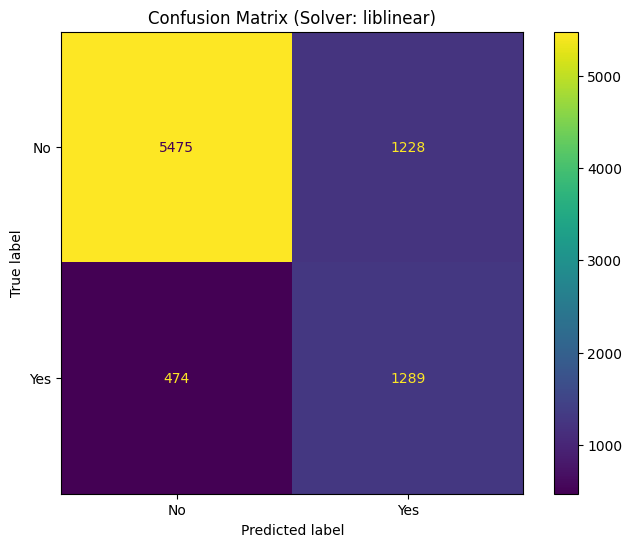


Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.51      0.73      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.72      0.77      0.73      8466
weighted avg       0.84      0.80      0.81      8466



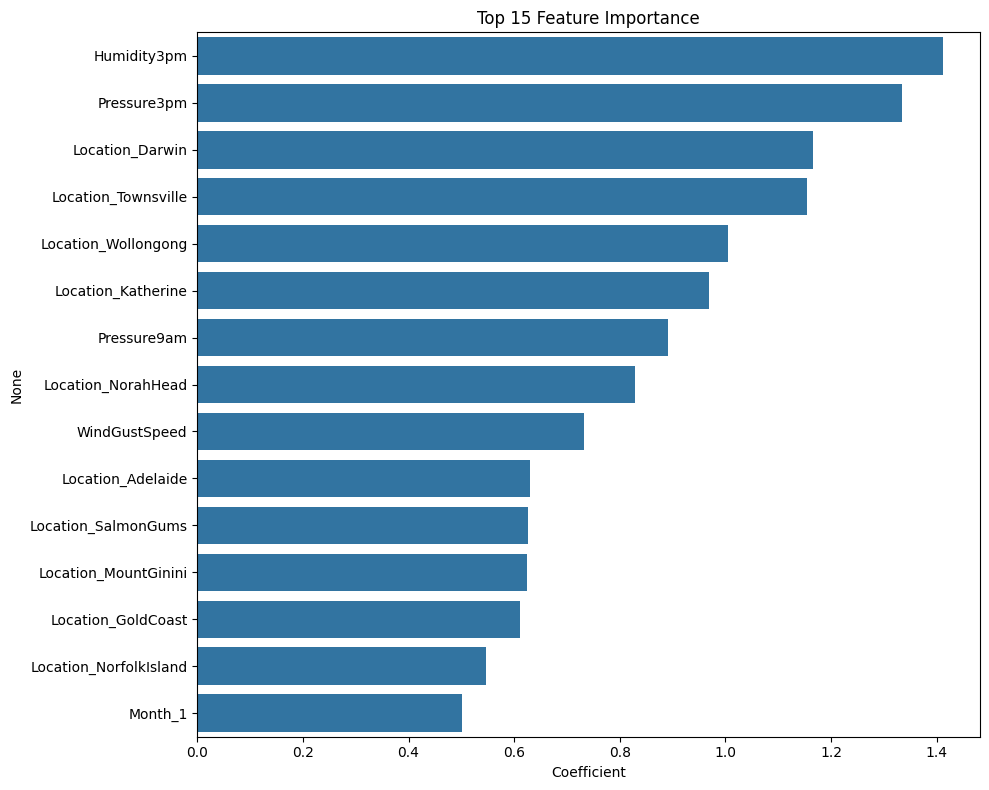

In [22]:
num_imputer = KNNImputer(n_neighbors=5).set_output(transform="pandas")
X_train_num = num_imputer.fit_transform(origin_X_train_num)
X_test_num = num_imputer.transform(origin_X_test_num)

cat_imputer = SimpleImputer(strategy="most_frequent").set_output(transform="pandas")
X_train_cat = cat_imputer.fit_transform(origin_X_train_cat)
X_test_cat = cat_imputer.transform(origin_X_test_cat)
##################################################
scaler = StandardScaler().set_output(transform="pandas")
X_train_num = scaler.fit_transform(X_train_num)
X_test_num = scaler.transform(X_test_num)

if X_train_num.isna().sum().sum() > 0:
    X_train_num = X_train_num.fillna(0)
    print("Filled NaNs in training numerical data with 0")

if X_test_num.isna().sum().sum() > 0:
    X_test_num = X_test_num.fillna(0)
    print("Filled NaNs in test numerical data with 0")
##################################################
encoder = OneHotEncoder(
    drop="if_binary", sparse_output=False, handle_unknown="ignore"
).set_output(transform="pandas")
X_train_cat = encoder.fit_transform(X_train_cat)
X_test_cat = encoder.transform(X_test_cat)
##################################################
X_train = pd.concat([X_train_num, X_train_cat], axis=1)
X_test = pd.concat([X_test_num, X_test_cat], axis=1)
##################################################
if X_train.isna().sum().sum() > 0:
    X_train = X_train.fillna(0)
    print("Filled remaining NaNs in training data with 0")

if X_test.isna().sum().sum() > 0:
    X_test = X_test.fillna(0)
    print("Filled remaining NaNs in test data with 0")
##################################################

clf_final, best_solver, results = compare_solvers(X_train, y_train, X_test, y_test)

#### `SMOTE`

RainTomorrow
No     103613
Yes    103613
Name: count, dtype: int64

Comparing different solvers:

Results for solver: liblinear
Accuracy: 0.7997
Weighted F1-score: 0.8112

Results for solver: lbfgs
Accuracy: 0.7994
Weighted F1-score: 0.8110

Results for solver: newton-cg
Accuracy: 0.7996
Weighted F1-score: 0.8111

Results for solver: sag
Accuracy: 0.7997
Weighted F1-score: 0.8112

Results for solver: saga
Accuracy: 0.7997
Weighted F1-score: 0.8112

Best solver: liblinear

Confusion Matrix:


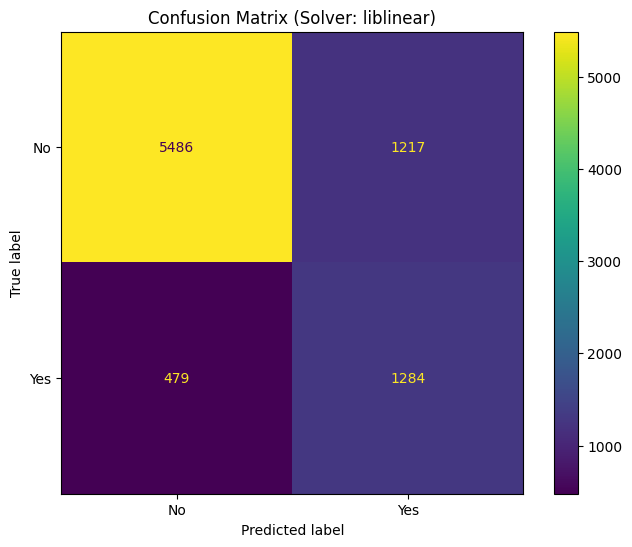


Classification Report:
              precision    recall  f1-score   support

          No       0.92      0.82      0.87      6703
         Yes       0.51      0.73      0.60      1763

    accuracy                           0.80      8466
   macro avg       0.72      0.77      0.73      8466
weighted avg       0.84      0.80      0.81      8466



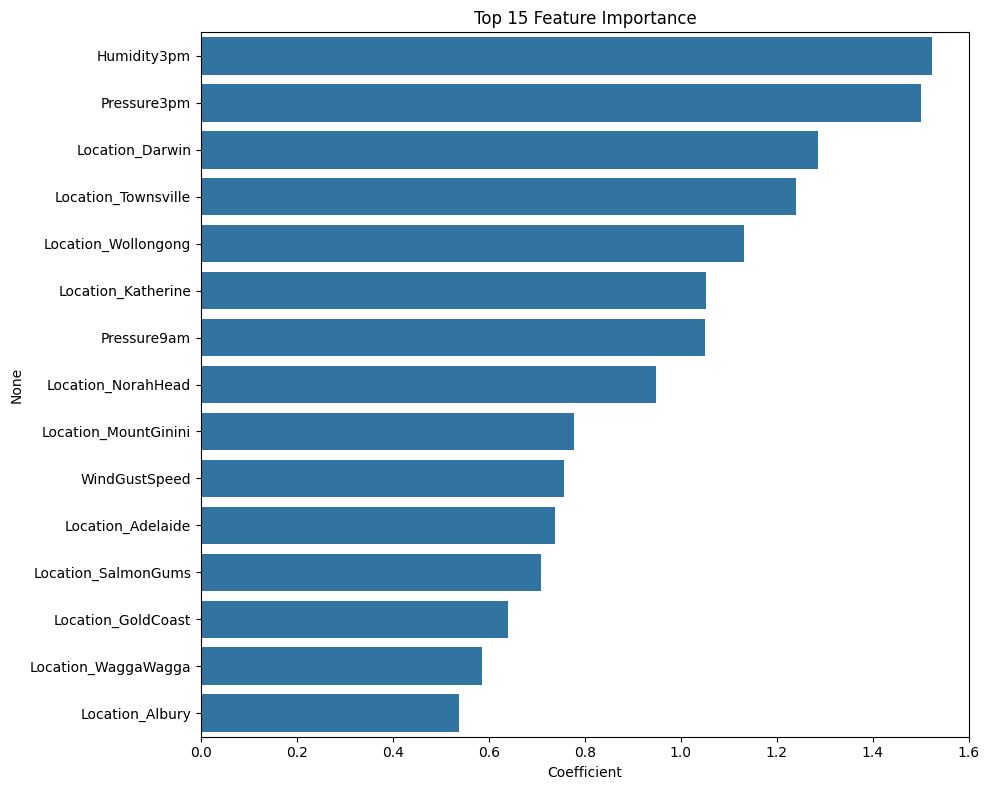

In [23]:
smote = SMOTE(random_state=42)
X_train_bal, y_train_bal = smote.fit_resample(X_train, y_train)

print(y_train_bal.value_counts())

clf_final, best_solver, results = compare_solvers(
    X_train_bal, y_train_bal, X_test, y_test
)

## Висновки

- Видалено ознаки, де пропущено більше 35% значень.
- Заповнено пропущені значення у числових даних за допомогою `SimpleImputer` та `KNNImputer`.
- Після очищення отримано 133727 записів у тренувальній вибірці та 8466 записів у тестовій.
- Проведено експерименти з `Logistic Regression` з різними методами оптимізації:
    - `liblinear`
    - `lbfgs`
    - `newton-cg`
    - `sag`
    - `saga`

- Результати без балансування класів:

        - Найкращий результат показав метод `liblinear`.
        - Точність (`Accuracy`): 0.8011.
        - Середнє значення `F1-score`: 0.8118.

- Результати після балансування за допомогою `SMOTE`:

        - Найкращий результат у `newton-cg` та `liblinear`.
        - Точність залишилася на рівні 0.7997-0.8000.
        - Незначне покращення `F1-score` до 0.8112.

- Модель демонструє високу точність у прогнозуванні `No` (без дощу), але гірше передбачає `Yes` (дощ).
- `Recall` для `Yes` класу підвищився після застосування `SMOTE` (з 0.71 до 0.73) - модель краще виявляє дощові дні.
- Використання різних ітераційних методів (`solvers`) не дало значного приросту точності.

Отже, використання логістичної регресії дає достатньо високу точність, але є проблеми з дисбалансом класів.
Застосування `SMOTE` трохи покращило прогнозування класу (`Yes`), але незначно вплинуло на загальну точність.